In [66]:
import numpy as np
import pandas as pd
import geopy
import pickle
import gzip
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.dpi"] = 100

The goal is to estimate the distance traveled so far in a given lap, assuming no lane changes, and that the human driver would keep the vehicle on lane-center with minimal deviation from lap to laps. 

Total track distance:
- left lane: 3709.23 m
- right lane: 3825.92 m

Approach 1: Simple speed integration

Assume that we have accurate vehicle longitudinal speed from CAN reading
- sampling frequency: 4hz

In [4]:
data_ver = '3'

with gzip.open(f'../data/segment_noise_v{data_ver}/ll_seg_500_noise_v{data_ver}.pkl.gzip', 'rb') as f:
    ll_seg_noise = pickle.load(f)
with gzip.open(f'../data/segment_noise_v{data_ver}/rl_seg_500_noise_v{data_ver}.pkl.gzip', 'rb') as f:
    rl_seg_noise = pickle.load(f)

In [6]:
len(ll_seg_noise)

500

In [19]:
def speed_integration(speed, sample_period=0.25):
    dist = 0
    for i in np.arange(1, len(speed)):
        dist += 0.5 * (speed[i-1] + speed[i]) * sample_period
    return dist

In [23]:
# left lane

ll_seg_dist_est = []
ll_seg_dist_gt = []

for seg in ll_seg_noise:
    dist_est = scipy.integrate.cumtrapz(
        seg['Vx'].to_numpy(), dx=0.25
    )[-1]
    dist_gt = seg.iloc[-1]['Distance horizontal (m)'] - seg.iloc[0]['Distance horizontal (m)']
    ll_seg_dist_est.append(dist_est)
    ll_seg_dist_gt.append(dist_gt)

In [30]:
# right lane

rl_seg_dist_est = []
rl_seg_dist_gt = []

for seg in rl_seg_noise:
    dist_est = scipy.integrate.cumtrapz(
        seg['Vx'].to_numpy(), dx=0.25
    )[-1]
    dist_gt = seg.iloc[-1]['Distance horizontal (m)'] - seg.iloc[0]['Distance horizontal (m)']
    rl_seg_dist_est.append(dist_est)
    rl_seg_dist_gt.append(dist_gt)

In [33]:
ll_err = np.array(ll_seg_dist_est) - np.array(ll_seg_dist_gt)
rl_err = np.array(rl_seg_dist_est) - np.array(rl_seg_dist_gt)

In [56]:
round(abs(ll_err).mean(), 4), round(abs(ll_err).std(), 5)

(0.0079, 0.0062)

In [57]:
round(abs(rl_err).mean(), 4), round(abs(rl_err).std(), 5)

(0.0081, 0.00612)

Text(0.5, 1.0, 'Trajectory segment length distribution, 500 samples')

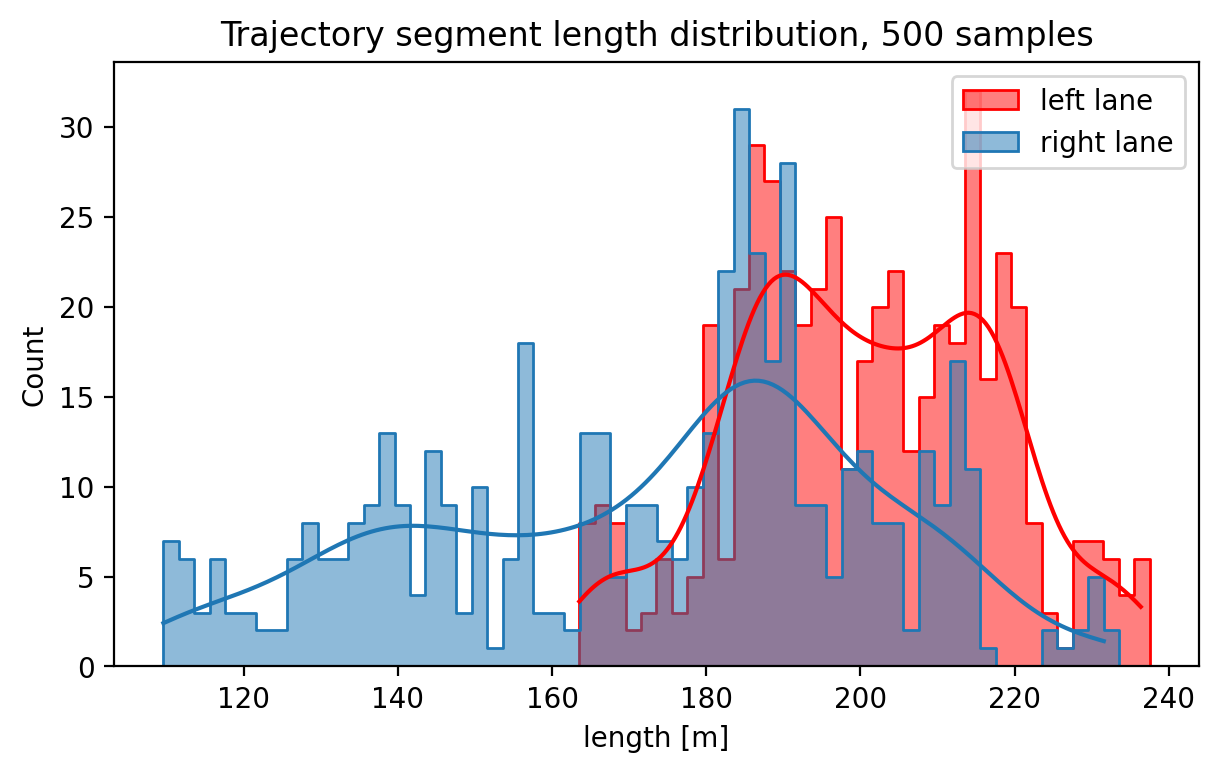

In [64]:
plt.figure(figsize=(7,4), dpi=100)
sns.histplot(ll_seg_dist_gt, binwidth=2, label='left lane', kde=True, color='red', element = "step")
sns.histplot(rl_seg_dist_gt, binwidth=2, label='right lane', kde=True, element = "step")
plt.legend()
plt.xlabel('length [m]')
plt.title('Trajectory segment length distribution, 500 samples')

Text(0.5, 1.0, 'Segment dist. est. error: lon. velocity integration, 500 samples')

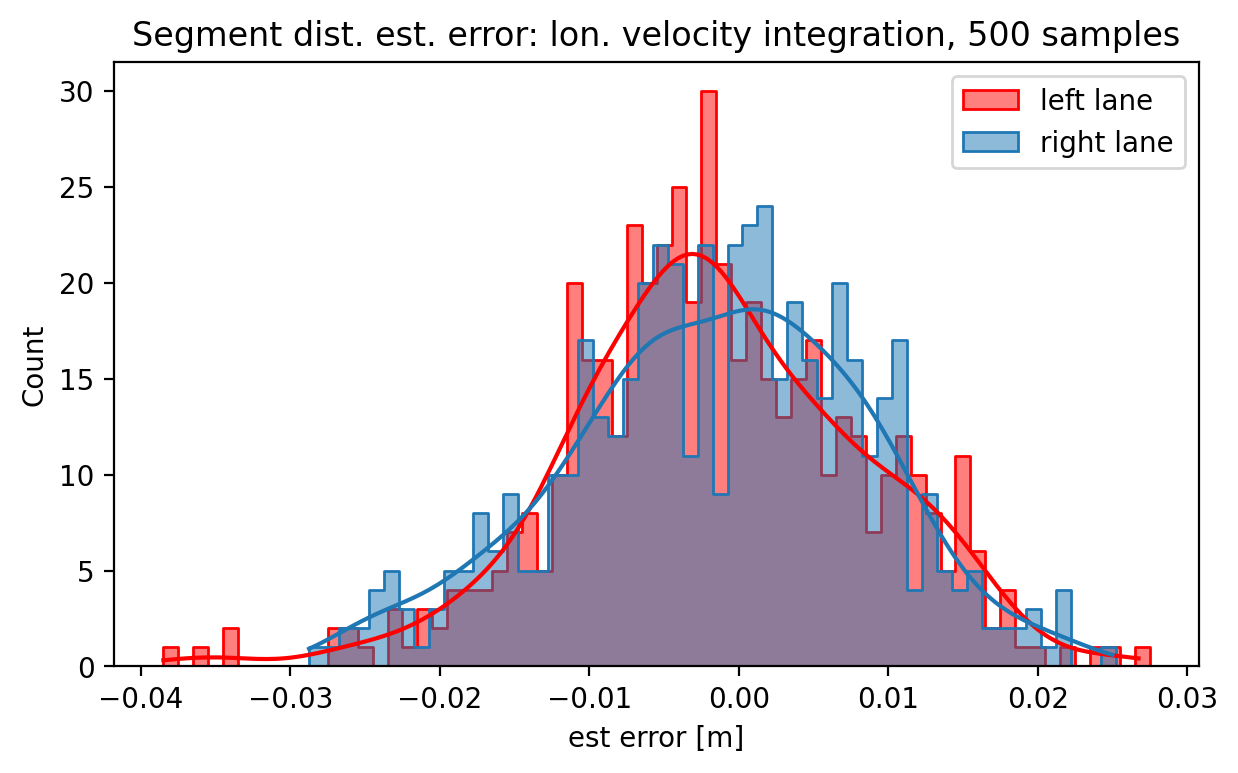

In [63]:
plt.figure(figsize=(7,4), dpi=100)
sns.histplot(ll_err, binwidth=0.001, label='left lane', kde=True, color='red', element = "step")
sns.histplot(rl_err, binwidth=0.001, label='right lane', kde=True, element = "step")
plt.legend()
plt.xlabel('est error [m]')
plt.title('Segment dist. est. error: lon. velocity integration, 500 samples')

In [67]:
ll_center = pd.read_csv('../data/acm_track/augmented_lane_line/ll_lane.csv.gzip', compression='gzip')
rl_center = pd.read_csv('../data/acm_track/augmented_lane_line/rl_lane.csv.gzip', compression='gzip')

In [72]:
ll_dist_est = scipy.integrate.cumtrapz(
        ll_center['Vx'].to_numpy(), dx=0.01
    )[-1]
ll_dist_gt = ll_center.iloc[-1]['Distance horizontal (m)'] - ll_center.iloc[0]['Distance horizontal (m)']
ll_dist_est, ll_dist_gt

(3705.3954499997844, 3705.409)

In [73]:
ll_dist_est - ll_dist_gt

-0.013550000215673208

In [74]:
rl_dist_est = scipy.integrate.cumtrapz(
        rl_center['Vx'].to_numpy(), dx=0.01
    )[-1]
rl_dist_gt = rl_center.iloc[-1]['Distance horizontal (m)'] - rl_center.iloc[0]['Distance horizontal (m)']
rl_dist_est, rl_dist_gt

(3775.1380999997637, 3775.196)

In [75]:
rl_dist_est - rl_dist_gt

-0.057900000236259075